In [1]:
#%env CUDA_VISIBLE_DEVICES=1

In [1]:
from collections import Counter
from glob import glob
from itertools import islice

import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import scipy
from scipy.cluster import hierarchy
import seaborn as sns
import torch
from sklearn.manifold import TSNE, Isomap
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from era_data import TabletPeriodDataset
from era_model import EraClassifier

# from lime import lime_image
# from skimage.segmentation import mark_boundaries

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load data and model

In [3]:
IMG_DIR = 'output/images_preprocessed'

VERSION_NAME = 'period_clf_bs16_lr5e-05_15epochs-resnet50-94936_samples_preprocessed-masked_March29-1000_test_val'

CKPT_FN = glob(f'lightning_logs/{VERSION_NAME}/checkpoints/*')[0]
CKPT_FN

'lightning_logs/period_clf_bs16_lr5e-05_15epochs-resnet50-94936_samples_preprocessed-masked_March29-1000_test_val/checkpoints/epoch=4-step=29041.ckpt'

In [4]:
num_classes = len(TabletPeriodDataset.PERIOD_INDICES) + 2
num_classes

24

In [5]:
%time model = EraClassifier.load_from_checkpoint(CKPT_FN, num_classes=num_classes)

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: user 739 ms, sys: 505 ms, total: 1.24 s
Wall time: 3.61 s


In [6]:
model.to(device);

In [7]:
model.eval();

In [8]:
test_ids = pd.read_csv(f'output/clf_ids/period-test-{VERSION_NAME}.csv', header=None)[0].astype(str)

In [9]:
len(test_ids)

1000

In [10]:
ds_test = TabletPeriodDataset(IDS=test_ids, mask=True, IMG_DIR=IMG_DIR)

Filtering 94936 IDS down to provided 1000...


In [11]:
def collate_fn(batch):
    
    data = torch.stack([torch.from_numpy(sample[1]) for sample in batch])
    labels = torch.tensor([sample[2] for sample in batch])

    return data, labels

In [12]:
dl_test = DataLoader(ds_test, batch_size=16, collate_fn = collate_fn, shuffle=False, num_workers=1)

# Calculate predictions

In [13]:
def dl2data(dl, MAX_N=None):
    logits = []
    y_true = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            y_true.append(y.numpy())
            logits.append(model(X.to(device)).cpu().numpy())
    y_true = np.hstack(y_true)
    logits = np.vstack(logits)
    return logits, y_true

In [14]:
logits, y_true = dl2data(dl_test)

  0%|          | 0/62 [00:00<?, ?it/s]

In [15]:
y_true.shape, logits.shape

((983,), (983, 24))

In [16]:
y_pred = logits.argmax(axis=-1)
y_prob = scipy.special.softmax(logits, axis=-1)

In [17]:
y_pred.shape, y_prob.shape

((983,), (983, 24))

In [18]:
(y_pred == y_true).mean()

0.7894201424211598

# Check metrics

In [19]:
EARLY_BRONZE = {
    'Old Akkadian', 'Ur III',
    'ED IIIb', 'Uruk III',
    'Proto-Elamite', 'Lagash II',
    'Ebla', 'ED IIIa', 'ED I-II',
    'Uruk IV', 'Linear Elamite',
    'Harappan'
    
}
MID_LATE_BRONZE = {
    'Early Old Babylonian',
    'Old Babylonian', 'Old Assyrian',
    'Middle Babylonian', 'Middle Assyrian',
    'Middle Elamite', 'Middle Hittite'
}
IRON = {
    'Neo-Babylonian', 'Neo-Assyrian',
    'Achaemenid', 'Hellenistic',
    'Neo-Elamite'
}
ERA_MAP = {
    **{K: 'EB' for K in EARLY_BRONZE},
    **{K: 'MLB' for K in MID_LATE_BRONZE},
    **{K: 'I' for K in IRON},
}

In [20]:
def explain(period):
    return f'{period} ({ERA_MAP.get(period, "?")})'
explain('Neo-Babylonian')

'Neo-Babylonian (I)'

In [21]:
idx2period = {v: k for k, v in TabletPeriodDataset.PERIOD_INDICES.items()}
idx2period[0] = 'other'

In [22]:
idx2period[0], idx2period[5]

('other', 'Neo-Babylonian')

In [23]:
list(set(y_true) | set(y_pred))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19]

In [24]:
indices = list(set(y_true) | set(y_pred))
print(len(indices))
print(indices)
PERIOD_LABELS = [explain(idx2period[i]) for i in indices]
print(PERIOD_LABELS)

18
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)', 'Uruk III (EB)', 'Lagash II (EB)', 'Ebla (EB)', 'ED IIIa (EB)', 'Hellenistic (I)', 'Middle Elamite (MLB)']


In [25]:
print(classification_report(y_true, y_pred, target_names=PERIOD_LABELS))

                            precision    recall  f1-score   support

                 other (?)       0.00      0.00      0.00         3
               Ur III (EB)       0.82      0.93      0.87       309
          Neo-Assyrian (I)       0.91      0.98      0.95       250
      Old Babylonian (MLB)       0.63      0.77      0.69       179
   Middle Babylonian (MLB)       0.66      0.34      0.45        56
        Neo-Babylonian (I)       0.75      0.61      0.67        49
         Old Akkadian (EB)       0.69      0.41      0.51        22
            Achaemenid (I)       1.00      0.21      0.35        19
Early Old Babylonian (MLB)       0.78      0.24      0.37        29
              ED IIIb (EB)       0.69      0.75      0.72        12
     Middle Assyrian (MLB)       0.83      0.33      0.48        15
        Old Assyrian (MLB)       0.87      0.59      0.70        22
             Uruk III (EB)       0.00      0.00      0.00         1
            Lagash II (EB)       0.83      0.83

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [26]:
# let's just use classes with support >=10, everything else goes to 0: other
COMMON_LABELS = list({k for k, v in Counter(y_true).items() if v >= 10})
print(f'Common labels: ({len(COMMON_LABELS)})')
[(i, explain(idx2period[i])) for i in COMMON_LABELS]

Common labels: (11)


[(1, 'Ur III (EB)'),
 (2, 'Neo-Assyrian (I)'),
 (3, 'Old Babylonian (MLB)'),
 (4, 'Middle Babylonian (MLB)'),
 (5, 'Neo-Babylonian (I)'),
 (6, 'Old Akkadian (EB)'),
 (7, 'Achaemenid (I)'),
 (8, 'Early Old Babylonian (MLB)'),
 (9, 'ED IIIb (EB)'),
 (10, 'Middle Assyrian (MLB)'),
 (11, 'Old Assyrian (MLB)')]

In [27]:
y_true_c = y_true.copy()
y_true_c[~np.isin(y_true, COMMON_LABELS)] = 0
print((~np.isin(y_true, COMMON_LABELS)).mean(), 'changed to "other"')

0.021363173957273652 changed to "other"


In [28]:
y_pred_c = y_pred.copy()
y_pred_c[~np.isin(y_pred, COMMON_LABELS)] = 0
print((~np.isin(y_pred, COMMON_LABELS)).mean(), 'changed to "other"')

0.01627670396744659 changed to "other"


In [29]:
indices_c = list(set(y_pred_c))
print(len(indices_c))
print(indices_c)
PERIOD_LABELS_C = [explain(idx2period[i]) for i in indices_c]
print(PERIOD_LABELS_C)

12
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)']


In [30]:
print(classification_report(y_true_c, y_pred_c, target_names=PERIOD_LABELS_C))

                            precision    recall  f1-score   support

                 other (?)       0.69      0.52      0.59        21
               Ur III (EB)       0.82      0.93      0.87       309
          Neo-Assyrian (I)       0.91      0.98      0.95       250
      Old Babylonian (MLB)       0.63      0.77      0.69       179
   Middle Babylonian (MLB)       0.66      0.34      0.45        56
        Neo-Babylonian (I)       0.75      0.61      0.67        49
         Old Akkadian (EB)       0.69      0.41      0.51        22
            Achaemenid (I)       1.00      0.21      0.35        19
Early Old Babylonian (MLB)       0.78      0.24      0.37        29
              ED IIIb (EB)       0.69      0.75      0.72        12
     Middle Assyrian (MLB)       0.83      0.33      0.48        15
        Old Assyrian (MLB)       0.87      0.59      0.70        22

                  accuracy                           0.79       983
                 macro avg       0.78      0.5

In [31]:
cm = confusion_matrix(y_true_c, y_pred_c)
cm # rows: ground truth; cols: prediction

array([[ 11,   1,   0,   6,   0,   2,   0,   0,   1,   0,   0,   0],
       [  2, 286,   3,  15,   0,   0,   2,   0,   0,   1,   0,   0],
       [  1,   0, 246,   2,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,  29,   4, 137,   4,   2,   1,   0,   1,   1,   0,   0],
       [  1,   9,   2,  21,  19,   1,   0,   0,   0,   1,   1,   1],
       [  0,   3,   5,   9,   2,  30,   0,   0,   0,   0,   0,   0],
       [  1,   3,   1,   7,   1,   0,   9,   0,   0,   0,   0,   0],
       [  0,   3,   1,   7,   2,   2,   0,   4,   0,   0,   0,   0],
       [  0,   7,   1,  13,   0,   1,   0,   0,   7,   0,   0,   0],
       [  0,   1,   1,   0,   0,   0,   1,   0,   0,   9,   0,   0],
       [  0,   3,   3,   2,   0,   0,   0,   0,   0,   1,   5,   1],
       [  0,   4,   3,   0,   1,   1,   0,   0,   0,   0,   0,  13]])

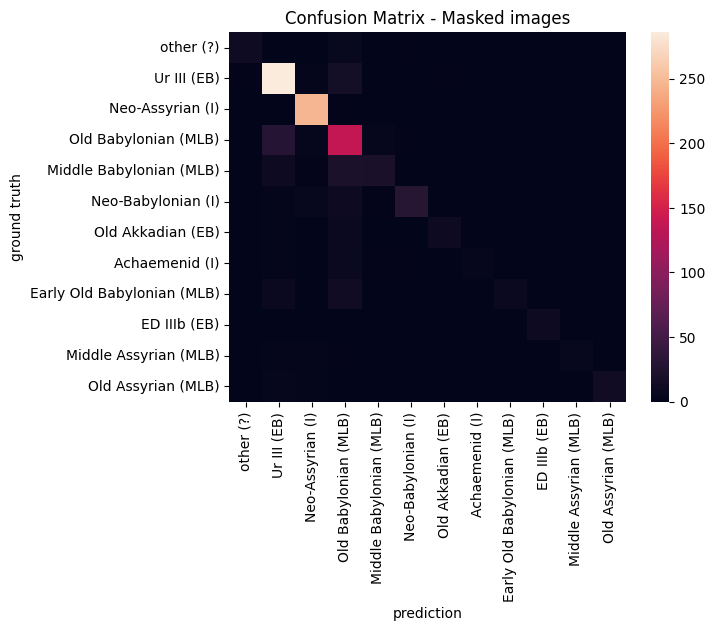

In [32]:
sns.heatmap(cm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth')
plt.title("Confusion Matrix - Masked images");

In [33]:
cm_rownorm = (cm / cm.sum(axis=1)[:, None])

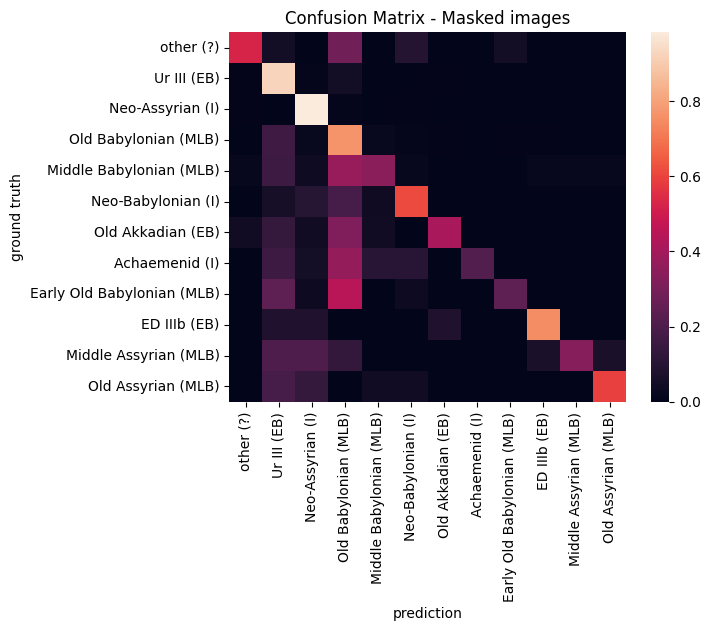

In [34]:
sns.heatmap(cm_rownorm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth')
plt.title("Confusion Matrix - Masked images");

In [35]:
cm_df = pd.DataFrame(cm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Achaemenid (I),Early Old Babylonian (MLB),ED IIIb (EB),Middle Assyrian (MLB),Old Assyrian (MLB)
other (?),11,1,0,6,0,2,0,0,1,0,0,0
Ur III (EB),2,286,3,15,0,0,2,0,0,1,0,0
Neo-Assyrian (I),1,0,246,2,0,1,0,0,0,0,0,0
Old Babylonian (MLB),0,29,4,137,4,2,1,0,1,1,0,0
Middle Babylonian (MLB),1,9,2,21,19,1,0,0,0,1,1,1
Neo-Babylonian (I),0,3,5,9,2,30,0,0,0,0,0,0
Old Akkadian (EB),1,3,1,7,1,0,9,0,0,0,0,0
Achaemenid (I),0,3,1,7,2,2,0,4,0,0,0,0
Early Old Babylonian (MLB),0,7,1,13,0,1,0,0,7,0,0,0
ED IIIb (EB),0,1,1,0,0,0,1,0,0,9,0,0


In [36]:
cm_rn_df = pd.DataFrame(cm_rownorm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_rn_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Achaemenid (I),Early Old Babylonian (MLB),ED IIIb (EB),Middle Assyrian (MLB),Old Assyrian (MLB)
other (?),0.523810,0.047619,0.000000,0.285714,0.000000,0.095238,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000
Ur III (EB),0.006472,0.925566,0.009709,0.048544,0.000000,0.000000,0.006472,0.000000,0.000000,0.003236,0.000000,0.000000
Neo-Assyrian (I),0.004000,0.000000,0.984000,0.008000,0.000000,0.004000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Old Babylonian (MLB),0.000000,0.162011,0.022346,0.765363,0.022346,0.011173,0.005587,0.000000,0.005587,0.005587,0.000000,0.000000
Middle Babylonian (MLB),0.017857,0.160714,0.035714,0.375000,0.339286,0.017857,0.000000,0.000000,0.000000,0.017857,0.017857,0.017857
Neo-Babylonian (I),0.000000,0.061224,0.102041,0.183673,0.040816,0.612245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Old Akkadian (EB),0.045455,0.136364,0.045455,0.318182,0.045455,0.000000,0.409091,0.000000,0.000000,0.000000,0.000000,0.000000
Achaemenid (I),0.000000,0.157895,0.052632,0.368421,0.105263,0.105263,0.000000,0.210526,0.000000,0.000000,0.000000,0.000000
Early Old Babylonian (MLB),0.000000,0.241379,0.034483,0.448276,0.000000,0.034483,0.000000,0.000000,0.241379,0.000000,0.000000,0.000000
ED IIIb (EB),0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.750000,0.000000,0.000000


In [37]:
cm_df.loc['Early Old Babylonian (MLB)']

other (?)                      0
Ur III (EB)                    7
Neo-Assyrian (I)               1
Old Babylonian (MLB)          13
Middle Babylonian (MLB)        0
Neo-Babylonian (I)             1
Old Akkadian (EB)              0
Achaemenid (I)                 0
Early Old Babylonian (MLB)     7
ED IIIb (EB)                   0
Middle Assyrian (MLB)          0
Old Assyrian (MLB)             0
Name: Early Old Babylonian (MLB), dtype: int64

In [38]:
cm_rn_df.loc['Early Old Babylonian (MLB)']

other (?)                     0.000000
Ur III (EB)                   0.241379
Neo-Assyrian (I)              0.034483
Old Babylonian (MLB)          0.448276
Middle Babylonian (MLB)       0.000000
Neo-Babylonian (I)            0.034483
Old Akkadian (EB)             0.000000
Achaemenid (I)                0.000000
Early Old Babylonian (MLB)    0.241379
ED IIIb (EB)                  0.000000
Middle Assyrian (MLB)         0.000000
Old Assyrian (MLB)            0.000000
Name: Early Old Babylonian (MLB), dtype: float64

# Hierarchical clustering on confusion matrix

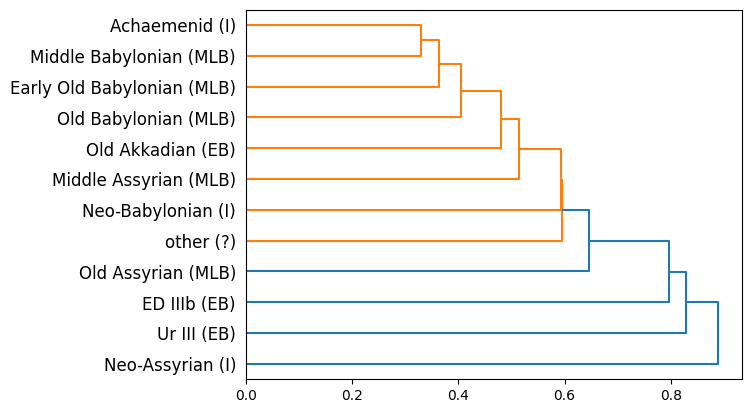

In [39]:
Y = hierarchy.distance.pdist(cm_rownorm, metric='euclidean')

Z = hierarchy.linkage(Y, method='single')

ax = hierarchy.dendrogram(Z, show_contracted=True, labels=PERIOD_LABELS_C, orientation='right')

# Clustering feature vectors using model as feature extractor

In [40]:
activation = {}
def get_activation(name):
    def hook(model, inp, output):
        activation[name] = output.detach()
    return hook

In [41]:
model.core.avgpool.register_forward_hook(get_activation('ap'))
# model.core.fc.register_forward_hook(get_activation('fc'))

In [42]:
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [43]:
def extract_features(dl, MAX_N=None):
    outs = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for _, X, y, _, _ in gen:
            model(X.to(device))
            outs.append(activation['ap'].cpu().numpy()[..., 0, 0])
    return np.vstack(outs)

In [44]:
feats = extract_features(dl_test)

  0%|          | 0/62 [00:00<?, ?it/s]

In [45]:
feats

array([[0.38996184, 0.42592302, 0.3365916 , ..., 0.14361796, 0.926222  ,
        0.5432665 ],
       [0.5011685 , 1.1177613 , 0.3482694 , ..., 0.4638743 , 0.051291  ,
        0.7101055 ],
       [0.2204605 , 0.79244554, 0.19550326, ..., 0.15942067, 0.12623492,
        0.5748735 ],
       ...,
       [1.0321742 , 1.3420384 , 0.6012249 , ..., 0.10066097, 0.33416155,
        0.22240916],
       [1.1771125 , 1.4501128 , 0.80036443, ..., 0.2544091 , 0.26109725,
        0.3136225 ],
       [0.5125926 , 0.5804542 , 0.24085474, ..., 0.2731009 , 0.31841683,
        0.46305734]], dtype=float32)

In [46]:
feats.shape

(983, 2048)

In [47]:
%time F = TSNE(n_components=2, init='pca').fit_transform(feats)
# learning_rate='auto' -- https://www.pythonfixing.com/2021/11/fixed-sklearnmanifoldtsne-typeerror.html

CPU times: user 16.7 s, sys: 760 ms, total: 17.5 s
Wall time: 3.33 s


In [48]:
%time F2 = Isomap(n_components=10).fit_transform(feats)

CPU times: user 762 ms, sys: 340 ms, total: 1.1 s
Wall time: 5.5 s


Text(0.5, 1.0, 'ISOMAP')

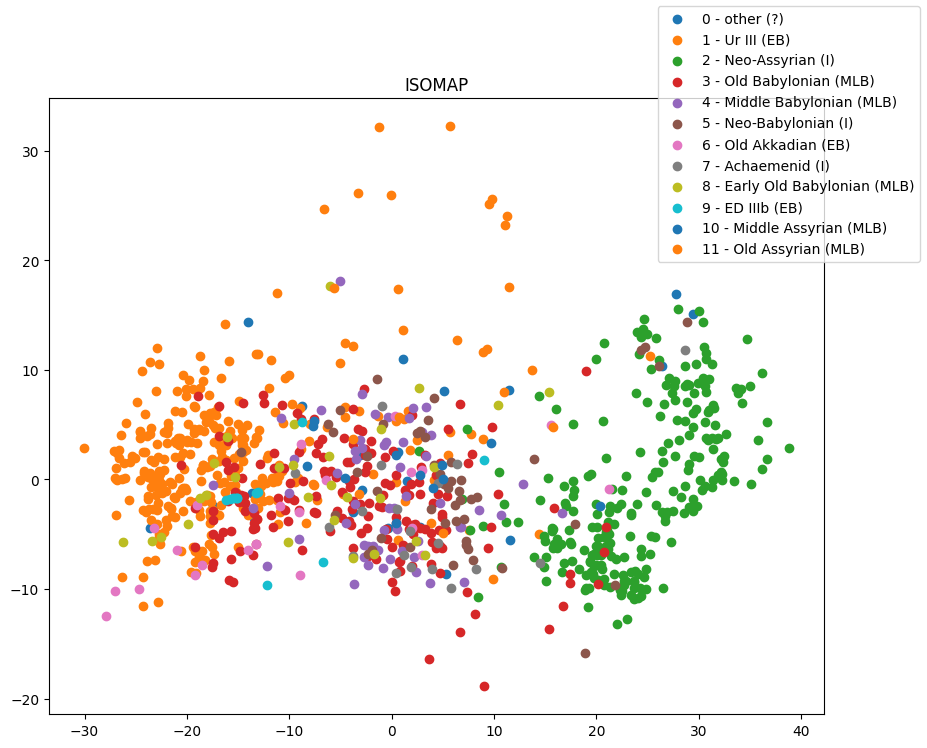

In [49]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
for period in set(y_true_c):
    ax.scatter(F2[y_true_c == period, 0], F2[y_true_c == period, 4], label=f'{period} - {explain(idx2period[period])}')
fig.legend();
plt.title('ISOMAP')

In [50]:
idx2period[period]

'Old Assyrian'

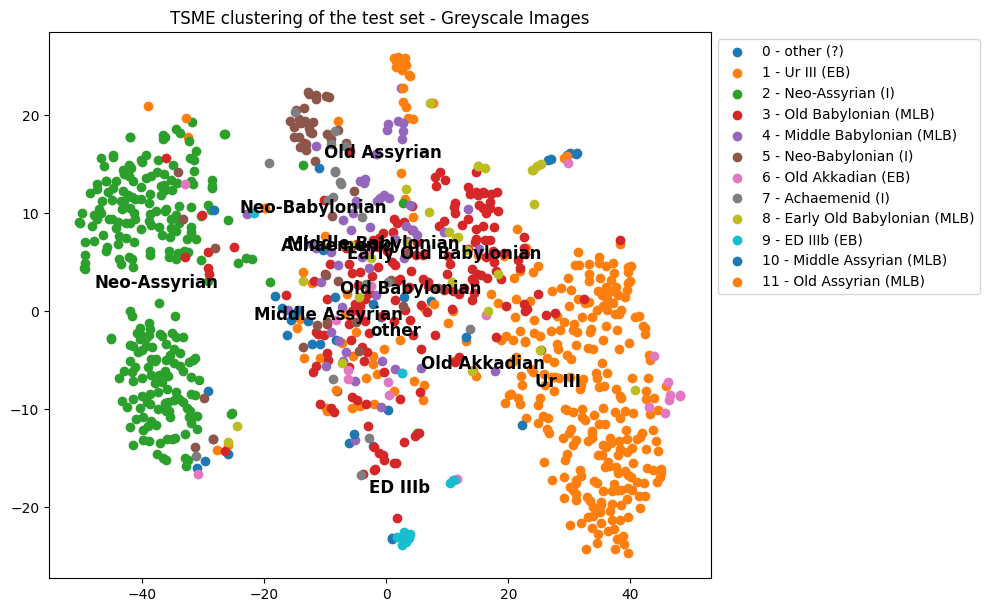

In [51]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

for period in set(y_true_c):
    period_data = F[y_true_c == period]
    
    # Scatter plot for the period.
    ax.scatter(period_data[:, 0], period_data[:, 1], label=f'{period} - {explain(idx2period[period])}')
    
    centroid = np.mean(period_data, axis=0)
    
    ax.text(centroid[0], centroid[1], f'{idx2period[period]}', horizontalalignment='center', verticalalignment='center', fontsize=12, weight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.title('TSME clustering of the test set - Greyscale Images')
scatter_pdf_path = 'output/plots/TSNEclusteringGreyscale.pdf'
plt.savefig(scatter_pdf_path, format='pdf')

#plt.show()

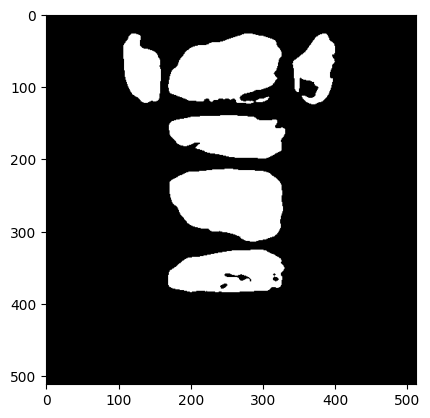

In [52]:
ID = np.random.choice(np.where(y_true == 2)[0])
plt.imshow(ds_test[ID][1], cmap='gray');

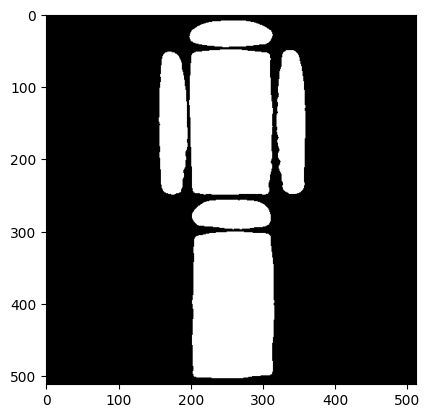

In [53]:
ID = np.random.choice(np.where(y_true == 5)[0])
plt.imshow(ds_test[ID][1], cmap='gray');

# Visualize mistakes

In [54]:
mistake_indices = np.where(y_true != y_pred)[0]
mistake_indices

array([ 72,  85,  88,  93,  96, 182, 189, 204, 219, 220, 225, 227, 228,
       232, 233, 239, 240, 241, 242, 245, 247, 249, 251, 254, 274, 275,
       278, 281, 323, 338, 340, 347, 348, 351, 354, 355, 356, 359, 362,
       363, 364, 365, 366, 369, 372, 373, 374, 377, 379, 382, 398, 399,
       400, 401, 402, 403, 407, 411, 412, 416, 417, 418, 419, 420, 424,
       425, 426, 427, 431, 432, 433, 435, 438, 439, 442, 443, 445, 446,
       447, 449, 450, 454, 456, 457, 459, 461, 465, 466, 467, 468, 469,
       470, 471, 472, 473, 474, 475, 477, 479, 482, 483, 487, 490, 491,
       492, 496, 499, 500, 501, 502, 505, 517, 520, 527, 528, 531, 562,
       574, 575, 576, 581, 582, 591, 592, 600, 603, 606, 607, 613, 614,
       615, 618, 619, 620, 621, 626, 629, 631, 634, 636, 637, 641, 643,
       646, 648, 649, 655, 661, 662, 663, 664, 665, 666, 669, 670, 674,
       706, 788, 789, 790, 792, 795, 810, 813, 814, 816, 817, 818, 820,
       826, 827, 831, 842, 843, 869, 870, 873, 878, 880, 881, 88

In [55]:
mistake_indices.shape

(207,)

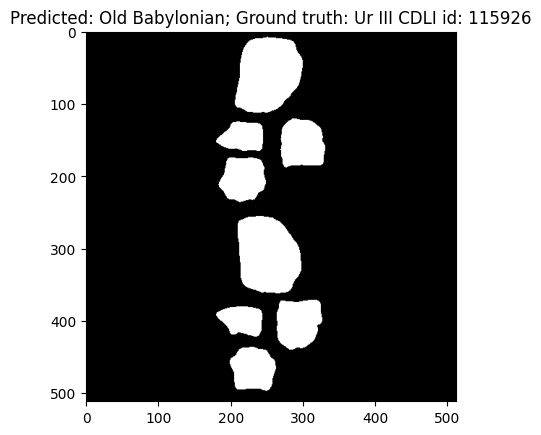

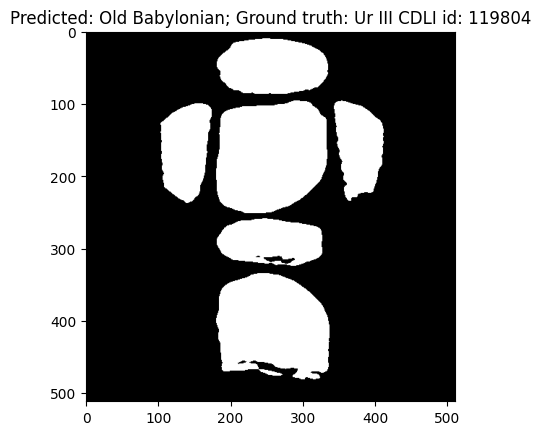

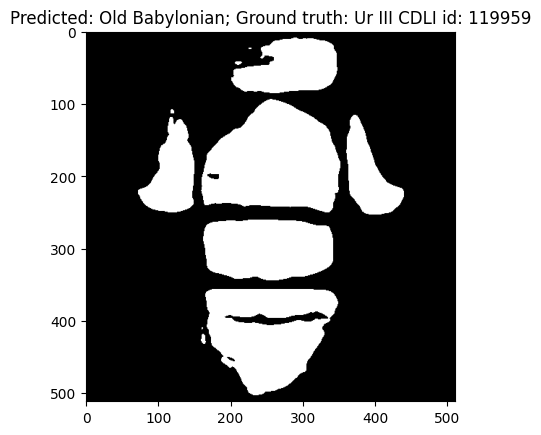

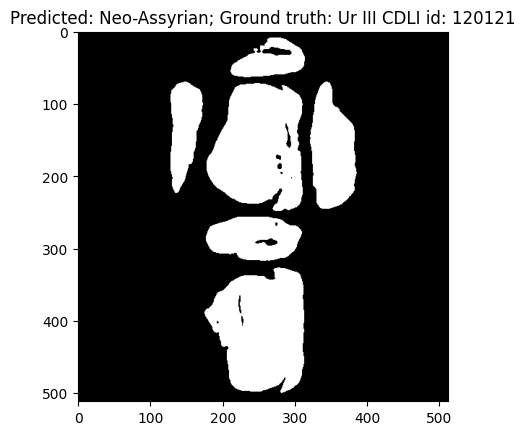

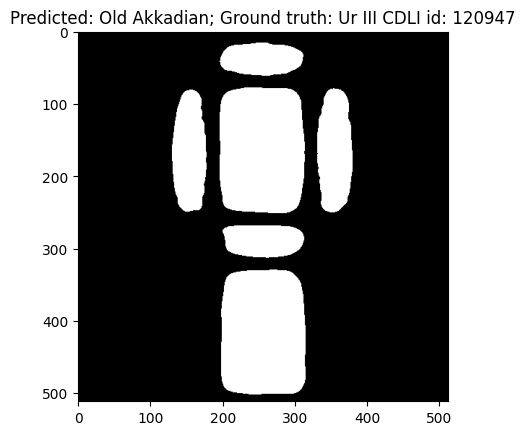

In [56]:
for idx in mistake_indices[:5]:
    
    cdli_id, X, y, _, _ = ds_test[idx]
    pred = y_pred[idx]
    
    plt.imshow(X, cmap='gray')
    plt.title(f'Predicted: {idx2period[pred]}; Ground truth: {idx2period[y]} CDLI id: {cdli_id}')
    plt.show()

# Explain predictions with Lime

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [72]:
# def preprocess_transform(img):
#     return img

In [73]:
# def batch_predict(X):
#     assert len(X.shape) == 4
#     # Lime adds channel dimension (gray2rgb); we remove it
#     # it also requires float64 (double) but our model needs float32
#     X_gray = X[..., 0].astype(np.float32) / 255
#     logits = model(torch.tensor(X_gray).to(device)).detach().cpu().numpy()
# #     probs = clf.predict_proba(logits)
#     probs = scipy.special.softmax(logits, axis=-1)
#     return probs

In [74]:
# explainer = lime_image.LimeImageExplainer()

In [75]:
# def explain_idx(idx):
#     X, y = ds_test[idx]
    
#     explanation = explainer.explain_instance(
#         X.astype(np.float64) * 255,
#         batch_predict,
#     #     top_labels=3,
#     #     hide_color=0,
#         batch_size=16,
#         num_samples=1000
#     )
    
#     top_label = explanation.top_labels[0]
    
#     temp, mask = explanation.get_image_and_mask(
#         top_label,
#         positive_only=False,
#         num_features=20,
#         hide_rest=False
#     )
    
#     img_boundary = mark_boundaries(temp/255.0, mask)
    
#     print(f'Item {idx}:')
#     print(f'Ground truth:\t{ERAS_SHORT[y]} ({y})')
#     print(f'Prediction:\t{ERAS_SHORT[top_label]} ({top_label})')

#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#     axs[0].imshow(X, cmap='gray');
#     axs[1].imshow(img_boundary);
#     plt.show()

In [76]:
# for i in range(10):
#     explain_idx(i)